# <a id='toc1_'></a>[Merged notebooks for Not Supported CIViC and MOA evidence (assertion analysis)](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Merged notebooks for Not Supported CIViC and MOA evidence (assertion analysis)](#toc1_)    
  - [Merge CIViC and MOA Summary Variant Dataframes](#toc1_1_)    
    - [Summary Table 1](#toc1_1_1_)    
    - [Summary Table 2](#toc1_1_2_)    
    - [Summary Table 3](#toc1_1_3_)    
    - [Summary Table 4](#toc1_1_4_)    
    - [Summary Table 5](#toc1_1_5_)    
    - [Summary Table 6](#toc1_1_6_)    
  - [Merge CIViC and MOA Summary Evidence Dataframes](#toc1_2_)    
  - [Merge CIViC and MOA Summary Impact Dataframes](#toc1_3_)    
    - [Merge aspects of the dataframe (number of evidence items, variants, impact score)](#toc1_3_1_)    
    - [Calculate the ratio of features/variants that come from MOA](#toc1_3_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
from pathlib import Path
import zipfile
import pandas as pd
from civicpy import civic as civicpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.pyplot import figure
from typing import Dict
import json
import requests
from ga4gh.core import sha512t24u #pip install ga4gh.vrs
from matplotlib.colors import ListedColormap

## <a id='toc1_1_'></a>[Merge CIViC and MOA Summary Variant Dataframes](#toc0_)

In [2]:
civic_variant_ids = civicpy.get_all_variants(include_status=["accepted", "submitted"])
total_number_variants = len(civic_variant_ids)
f"Total Number of variants in CIViC: {total_number_variants}"

'Total Number of variants in CIViC: 3526'

In [3]:
def get_feature_digest(feature: Dict) -> str:
    """Get digest for feature

    :param feature: MOA feature
    :return: Digest
    """
    attrs = json.dumps(
        feature["attributes"][0],
        sort_keys=True,
        separators=(",", ":"),
        indent=None
    ).encode("utf-8")
    return sha512t24u(attrs)

Create dictionary for MOA Feature ID -> Feature Type

In [4]:
r = requests.get("https://moalmanac.org/api/features")
if r.status_code == 200:
    feature_data = r.json()

features = {}

for feature in feature_data:
    feature_id = feature["feature_id"]
    digest = get_feature_digest(feature)
    features[digest] = feature["feature_type"]

count_unique_feature_ids = len(features.keys())
f"Total Number of variants in MOA: {count_unique_feature_ids}"

'Total Number of variants in MOA: 429'

Add all variants from CIViC and MOA

In [5]:
merged_variant_total = total_number_variants+count_unique_feature_ids
merged_variant_total =float(merged_variant_total)
merged_variant_total

3955.0

Import summary tables from source notebooks

In [6]:
for_merge_all_variant_percent_of_civic_df = pd.read_csv("normalization_analysis_output/for_merge_all_variant_percent_of_civic_df.csv", sep=",")
for_merge_all_variant_percent_of_moa_df = pd.read_csv("normalization_analysis_output/for_merge_all_variant_percent_of_moa_df.csv", sep=",")

Merge CIViC and MOA sumary tables

In [7]:
merged_all_variants_df = pd.merge(for_merge_all_variant_percent_of_civic_df, for_merge_all_variant_percent_of_moa_df, on="Variant Category",how="outer")
merged_all_variants_df = merged_all_variants_df.replace(np.nan, 0, regex=True)

### <a id='toc1_1_1_'></a>[Summary Table 1](#toc0_)

The table below shows the 3 categories that CIViC and MOA variants were divided into after normalization and what percentage they make up of all variants in the respective source data.

In [8]:
merged_civic_moa_summary_table_1 = merged_all_variants_df.drop(["Count of CIViC Variant Items per Category", "Count of MOA Features per Category"], axis=1)
merged_civic_moa_summary_table_1 = merged_civic_moa_summary_table_1.set_index("Variant Category")
merged_civic_moa_summary_table_1

,Percentage of all CIViC Variant Items,Percentage of all MOA Features
Variant Category,,
Normalized,1864 / 3519 (52.97%),179 / 428 (41.82%)
Unable to Normalize,92 / 3519 (2.61%),0
Not Supported,1563 / 3519 (44.42%),249 / 428 (58.18%)


### Building Summary Table 2

Add up variants from CIViC and MOA for each Variant Category

In [9]:
merged_all_variants_df["Count of CIViC Variant Items per Category"] = merged_all_variants_df["Count of CIViC Variant Items per Category"].astype(float)
merged_all_variants_df["Sum of Variants from CIViC and MOA per Category"] = merged_all_variants_df["Count of CIViC Variant Items per Category"]+ merged_all_variants_df["Count of MOA Features per Category"]

New column for the total combined variant number from CIViC and MOA

In [10]:
merged_all_variants_df["Sum of total Variants from CIViC and MOA"]= merged_variant_total

New percentage of each category of the total merged variants from CIViC and MOA

In [11]:
merged_all_variants_df["Merged Variant Percentage"]= (merged_all_variants_df["Sum of Variants from CIViC and MOA per Category"] / merged_all_variants_df["Sum of total Variants from CIViC and MOA"])*100
merged_all_variants_df=merged_all_variants_df.round({"Merged Variant Percentage":2})
merged_all_variants_df["Merged Variant Percentage"]= merged_all_variants_df["Merged Variant Percentage"].astype(str) + "%"

In [12]:
merged_all_variants_df["Sum of Variants from CIViC and MOA per Category"] = merged_all_variants_df["Sum of Variants from CIViC and MOA per Category"].astype(int)

merged_all_variants_df["Sum of total Variants from CIViC and MOA"] = merged_all_variants_df["Sum of total Variants from CIViC and MOA"].astype(int)

Merge fraction and percentage

In [13]:
merged_all_variants_df["Percentage of all Merged Variant Items"]= merged_all_variants_df["Sum of Variants from CIViC and MOA per Category"].astype(str)+" / "+merged_all_variants_df["Sum of total Variants from CIViC and MOA"].astype(str)+" ("+merged_all_variants_df["Merged Variant Percentage"].astype(str)+")"

### <a id='toc1_1_2_'></a>[Summary Table 2](#toc0_)

The table below shows the 3 categories that merged CIViC and MOA variants were divided into after normalization and what percentage they make up of all variants in the combined data. 

In [14]:
merged_civic_moa_summary_table_2 = merged_all_variants_df.drop(["Count of CIViC Variant Items per Category", "Percentage of all CIViC Variant Items", "Count of MOA Features per Category", "Percentage of all MOA Features", "Sum of Variants from CIViC and MOA per Category", "Sum of total Variants from CIViC and MOA","Merged Variant Percentage" ], axis=1)
merged_civic_moa_summary_table_2= merged_civic_moa_summary_table_2.set_index("Variant Category")
merged_civic_moa_summary_table_2

,Percentage of all Merged Variant Items
Variant Category,
Normalized,2043 / 3955 (51.66%)
Unable to Normalize,92 / 3955 (2.33%)
Not Supported,1812 / 3955 (45.82%)


### Building Summary Table 3

In [15]:
merged_all_variants_df["Count of CIViC Variant Items per Category"]= merged_all_variants_df["Count of CIViC Variant Items per Category"].astype(int)

merged_all_variants_df["Count of MOA Features per Category"]= merged_all_variants_df["Count of MOA Features per Category"].astype(int)

New percentage of CIViC contribution for each category

In [16]:
merged_all_variants_df["CIViC Variants of Category Percentage"]=(merged_all_variants_df["Count of CIViC Variant Items per Category"] / merged_all_variants_df["Sum of Variants from CIViC and MOA per Category"])*100
merged_all_variants_df=merged_all_variants_df.round({"CIViC Variants of Category Percentage":2})
merged_all_variants_df["CIViC Variants of Category Percentage"]= merged_all_variants_df["CIViC Variants of Category Percentage"].astype(str) + "%"

Merge fraction and percentage

In [17]:
merged_all_variants_df["Percentage of CIViC Variants of Category"]=merged_all_variants_df["Count of CIViC Variant Items per Category"].astype(str)+" / "+merged_all_variants_df["Sum of Variants from CIViC and MOA per Category"].astype(str)+" ("+merged_all_variants_df["CIViC Variants of Category Percentage"].astype(str)+")"

New percentage of MOA contribution for each category

In [18]:
merged_all_variants_df["MOA Variants of Category Percentage"]=(merged_all_variants_df["Count of MOA Features per Category"] / merged_all_variants_df["Sum of Variants from CIViC and MOA per Category"])*100
merged_all_variants_df=merged_all_variants_df.round({"MOA Variants of Category Percentage":2})
merged_all_variants_df["MOA Variants of Category Percentage"]= merged_all_variants_df["MOA Variants of Category Percentage"].astype(str) + "%"

Merge fraction and percentage

In [19]:
merged_all_variants_df["Percentage of MOA Variants of Category"]=merged_all_variants_df["Count of MOA Features per Category"].astype(str)+" / "+merged_all_variants_df["Sum of Variants from CIViC and MOA per Category"].astype(str)+" ("+merged_all_variants_df["MOA Variants of Category Percentage"].astype(str)+")"

### <a id='toc1_1_3_'></a>[Summary Table 3](#toc0_)

The table below shows what percentage of the merged data originates from CIViC and MOA sources

In [20]:
merged_civic_moa_summary_table_3 = merged_all_variants_df.drop(["Count of CIViC Variant Items per Category", "Percentage of all CIViC Variant Items", "Count of MOA Features per Category", "Percentage of all MOA Features", "Sum of Variants from CIViC and MOA per Category", "Sum of total Variants from CIViC and MOA","Merged Variant Percentage","Percentage of all Merged Variant Items","CIViC Variants of Category Percentage", "MOA Variants of Category Percentage" ], axis=1)
merged_civic_moa_summary_table_3= merged_civic_moa_summary_table_3.set_index("Variant Category")
merged_civic_moa_summary_table_3

,Percentage of CIViC Variants of Category,Percentage of MOA Variants of Category
Variant Category,,
Normalized,1864 / 2043 (91.24%),179 / 2043 (8.76%)
Unable to Normalize,92 / 92 (100.0%),0 / 92 (0.0%)
Not Supported,1563 / 1812 (86.26%),249 / 1812 (13.74%)


### Building Summary Table 4

Import summary tables from source notebooks

In [103]:
for_merge_not_supported_variant_percent_of_civic_df = pd.read_csv("normalization_analysis_output/for_merge_not_supported_variant_percent_of_civic_df.csv", sep=",")
for_merge_not_supported_features_total_df = pd.read_csv("normalization_analysis_output/for_merge_not_supported_features_total_df.csv", sep=",")

Merge CIViC and MOA summary tables

In [22]:
merged_not_supported_variants_df = pd.merge(for_merge_not_supported_variant_percent_of_civic_df, for_merge_not_supported_features_total_df, on="Category",how="outer")
merged_not_supported_variants_df = merged_not_supported_variants_df.replace(np.nan, 0, regex=True)

### <a id='toc1_1_4_'></a>[Summary Table 4](#toc0_)

The table below shows the categories of Not Supported variants and what percentage of source (CIViC or MOA) variants they make up. These percentages will not add up to 100% because Not Supported variants make up 45.40% of CIViC variants and 57.01% of MOA variants.(Reference Summary Table 1- merged_civic_moa_summary_table_1)

In [23]:
merged_civic_moa_summary_table_3= merged_not_supported_variants_df.drop(["Count of CIViC Variant Items per Category","Count of MOA Features per Category"], axis=1)
merged_civic_moa_summary_table_3= merged_civic_moa_summary_table_3.set_index("Category")
merged_civic_moa_summary_table_3

,Percent of all CIViC Variant Items,Percent of all MOA Features
Category,,
Expression,287 / 3519 (8.16%),11 / 428 (2.57%)
Epigenetic Modification,14 / 3519 (0.40%),0 / 428 (0.00%)
Fusion,294 / 3519 (8.35%),0 / 428 (0.00%)
Protein Consequence,127 / 3519 (3.61%),174 / 428 (40.65%)
Gene Function,91 / 3519 (2.59%),0 / 428 (0.00%)
Rearrangements,52 / 3519 (1.48%),38 / 428 (8.88%)
Copy Number,34 / 3519 (0.97%),17 / 428 (3.97%)
Other,86 / 3519 (2.44%),9 / 428 (2.10%)
Genotypes Easy,10 / 3519 (0.28%),0 / 428 (0.00%)


### Building Summary Table 5

Add up evidence from CIViC and MOA for each Variant Category

In [24]:
merged_not_supported_variants_df["Sum of Variants from CIViC and MOA per Category"]=merged_not_supported_variants_df["Count of CIViC Variant Items per Category"]+merged_not_supported_variants_df["Count of MOA Features per Category"]
merged_not_supported_variants_df["Sum of total Variants from CIViC and MOA"]= int(merged_variant_total)

New percentage of each category of the total merged variants from CIViC and MOA

In [25]:
merged_not_supported_variants_df["Merged Not Supported Variant Category of Merged Total Percentage"]= (merged_not_supported_variants_df["Sum of Variants from CIViC and MOA per Category"] / merged_not_supported_variants_df["Sum of total Variants from CIViC and MOA"])*100
merged_not_supported_variants_df=merged_not_supported_variants_df.round({"Merged Not Supported Variant Category of Merged Total Percentage":2})
merged_not_supported_variants_df["Merged Not Supported Variant Category of Merged Total Percentage"]= merged_not_supported_variants_df["Merged Not Supported Variant Category of Merged Total Percentage"].astype(str) + "%"

Merge fraction and percentage

In [26]:
merged_not_supported_variants_df["Percentage of all Merged Variant Items"]= merged_not_supported_variants_df["Sum of Variants from CIViC and MOA per Category"].astype(str)+" / "+merged_not_supported_variants_df["Sum of total Variants from CIViC and MOA"].astype(str)+" ("+merged_not_supported_variants_df["Merged Not Supported Variant Category of Merged Total Percentage"].astype(str)+")"

### <a id='toc1_1_5_'></a>[Summary Table 5](#toc0_)

The table below shows the categories of Not Supported variants and what percentage of all variants (CIViC and MOA) they make up. These percentages will not add up to 100% because Not Supported variants make up 46.64% of all variants (CIViC and MOA). 

In [27]:
merged_civic_moa_summary_table_5 = merged_not_supported_variants_df.drop(["Count of CIViC Variant Items per Category", "Percent of all CIViC Variant Items", "Count of MOA Features per Category", "Percent of all MOA Features", "Sum of Variants from CIViC and MOA per Category", "Sum of total Variants from CIViC and MOA", "Merged Not Supported Variant Category of Merged Total Percentage"], axis=1)
merged_civic_moa_summary_table_5=merged_civic_moa_summary_table_5.set_index("Category")
merged_civic_moa_summary_table_5

,Percentage of all Merged Variant Items
Category,
Expression,298 / 3955 (7.53%)
Epigenetic Modification,14 / 3955 (0.35%)
Fusion,294 / 3955 (7.43%)
Protein Consequence,301 / 3955 (7.61%)
Gene Function,91 / 3955 (2.3%)
Rearrangements,90 / 3955 (2.28%)
Copy Number,51 / 3955 (1.29%)
Other,95 / 3955 (2.4%)
Genotypes Easy,10 / 3955 (0.25%)


### Building Summary Table 6

Add up all variants, for total number of Not Supported Variants

In [28]:
merged_not_supported_variant_total= merged_not_supported_variants_df["Sum of Variants from CIViC and MOA per Category"].sum()
merged_not_supported_variants_df["Merged Not Supported Variant Total"]=merged_not_supported_variant_total

New percentage of each category of the total merged variants from CIViC and MOA

In [29]:
merged_not_supported_variants_df["Merged Not Supported Variant Category of Not Supported Percentage"]= (merged_not_supported_variants_df["Sum of Variants from CIViC and MOA per Category"] / merged_not_supported_variants_df["Merged Not Supported Variant Total"])*100
merged_not_supported_variants_df=merged_not_supported_variants_df.round({"Merged Not Supported Variant Category of Not Supported Percentage":2})
merged_not_supported_variants_df["Merged Not Supported Variant Category of Not Supported Percentage"]= merged_not_supported_variants_df["Merged Not Supported Variant Category of Not Supported Percentage"].astype(str) + "%"

Merge fraction and percentage

In [30]:
merged_not_supported_variants_df["Percentage of all Not Supported Variant Items"]= merged_not_supported_variants_df["Sum of Variants from CIViC and MOA per Category"].astype(str)+" / "+merged_not_supported_variants_df["Merged Not Supported Variant Total"].astype(str)+" ("+merged_not_supported_variants_df["Merged Not Supported Variant Category of Not Supported Percentage"].astype(str)+")"

### <a id='toc1_1_6_'></a>[Summary Table 6](#toc0_)

The table below shows the categories of Not Supported variants the percent of each category of total merged Not Supported variants.

In [31]:
merged_civic_moa_summary_table_6 = merged_not_supported_variants_df.drop(["Count of CIViC Variant Items per Category", "Percent of all CIViC Variant Items", "Count of MOA Features per Category", "Percent of all MOA Features", "Sum of Variants from CIViC and MOA per Category", "Sum of total Variants from CIViC and MOA","Percentage of all Merged Variant Items","Merged Not Supported Variant Category of Merged Total Percentage", "Merged Not Supported Variant Total","Merged Not Supported Variant Category of Not Supported Percentage"], axis=1)
merged_civic_moa_summary_table_6=merged_civic_moa_summary_table_6.set_index("Category")
merged_civic_moa_summary_table_6

,Percentage of all Not Supported Variant Items
Category,
Expression,298 / 1812 (16.45%)
Epigenetic Modification,14 / 1812 (0.77%)
Fusion,294 / 1812 (16.23%)
Protein Consequence,301 / 1812 (16.61%)
Gene Function,91 / 1812 (5.02%)
Rearrangements,90 / 1812 (4.97%)
Copy Number,51 / 1812 (2.81%)
Other,95 / 1812 (5.24%)
Genotypes Easy,10 / 1812 (0.55%)


## <a id='toc1_2_'></a>[Merge CIViC and MOA Summary Evidence Dataframes](#toc0_)

In [32]:
civic_evidence_ids = civicpy.get_all_evidence(include_status=["accepted", "submitted"])

In [33]:
total_ac_sub_evidence = len(civic_evidence_ids)
f"Total Number of accepted and submitted evidence items in CIViC: {total_ac_sub_evidence}"

'Total Number of accepted and submitted evidence items in CIViC: 9939'

Create a dataframe for assertions and their associated feature + predictive implication


In [34]:
r = requests.get("https://moalmanac.org/api/assertions")
if r.status_code == 200:
    assertion_data = r.json()

transformed = []

# Mapping from feature ID to feature digest
feature_id_to_digest = {}

for assertion in assertion_data:
    assertion_id = assertion["assertion_id"]
    predictive_implication = assertion["predictive_implication"]

    if len(assertion["features"]) != 1:
        print(f"assertion id ({assertion_id}) does not have 1 feature")
        continue

    feature = assertion["features"][0]
    feature_id = feature["feature_id"]
    feature_digest = get_feature_digest(feature)

    feature_id_to_digest[feature_id] = digest

    transformed.append(
        {
            "assertion_id": assertion_id,
            "feature_id": feature_id,
            "feature_type": features[feature_digest],
            "predictive_implication": predictive_implication,
            "feature_digest": feature_digest
        }
    )
moa_df = pd.DataFrame(transformed)

In [35]:
total_len_assertions = len(moa_df.assertion_id.unique())
f"Total number of unique assertions (evidence items): {total_len_assertions}"

'Total number of unique assertions (evidence items): 894'

Add all evidence items(assertions) from CIViC and MOA

In [36]:
merged_evidence_total = total_ac_sub_evidence +total_len_assertions

Import summary tables from source notebooks

In [37]:
for_merge_all_variant_evidence_percent_of_civic_df = pd.read_csv("normalization_analysis_output/for_merge_all_variant_evidence_percent_of_civic_df.csv", sep=",")
for_merge_all_features_assertions_df = pd.read_csv("normalization_analysis_output/for_merge_all_features_assertions_df.csv", sep=",")

Merge CIViC and MOA summary tables

In [38]:
merged_all_evidence_df = pd.merge(for_merge_all_variant_evidence_percent_of_civic_df, for_merge_all_features_assertions_df, on="Variant Category",how="outer")
merged_all_evidence_df = merged_all_evidence_df.replace(np.nan, 0, regex=True)
merged_all_evidence_df["Count of MOA Assertions per Category"]=merged_all_evidence_df["Count of MOA Assertions per Category"].astype(int)


Summary Table 7: The table below shows what percentage of all evidence items in CIViC and MOA are associated with Normalized, Unable to Normalize, and Not Supported variants. This will not add up to 100% because evidence itmes may be used across multiple variants.

In [39]:
merged_civic_moa_summary_table_7 = merged_all_evidence_df.drop(["Count of CIViC Evidence Items per Category", "Count of MOA Assertions per Category"], axis=1)
merged_civic_moa_summary_table_7 = merged_civic_moa_summary_table_7.set_index("Variant Category")
merged_civic_moa_summary_table_7

,Percentage of all CIViC Evidence Items,Percentage of all MOA Assertions
Variant Category,,
Normalized,5851 / 9920 (58.98%),325 / 894 (36.35%)
Unable to Normalize,142 / 9920 (1.43%),0
Not Supported,4243 / 9920 (42.77%),569 / 894 (63.65%)


In [40]:
#add up variants from CIViC and MOA for each Variant Category
merged_all_evidence_df["Sum of Evidence from CIViC and MOA per Category"] = merged_all_evidence_df["Count of CIViC Evidence Items per Category"]+ merged_all_evidence_df["Count of MOA Assertions per Category"]

In [41]:
#new column for the total combined variant number from CIViC and MOA
merged_all_evidence_df["Sum of total Evidence from CIViC and MOA"] = merged_evidence_total

In [42]:
#new percentage of each category of the total merged variants from CIViC and MOA
merged_all_evidence_df["Merged Evidence Percentage"]= (merged_all_evidence_df["Sum of Evidence from CIViC and MOA per Category"] / merged_all_evidence_df["Sum of total Evidence from CIViC and MOA"])*100
merged_all_evidence_df=merged_all_evidence_df.round({"Merged Evidence Percentage":2})
merged_all_evidence_df["Merged Evidence Percentage"]= merged_all_evidence_df["Merged Evidence Percentage"].astype(str) + "%"

In [43]:
#merge fraction and percentage
merged_all_evidence_df["Percentage of all Merged Evidence Items"]= merged_all_evidence_df["Sum of Evidence from CIViC and MOA per Category"].astype(str)+" / "+merged_all_evidence_df["Sum of total Evidence from CIViC and MOA"].astype(str)+" ("+merged_all_evidence_df["Merged Evidence Percentage"].astype(str)+")"

Summary Table 8: The table below shows what percentage of all evidence items in merged CIViC and MOA data are associated with Normalized, Unable to Normalize, and Not Supported variants. This will not add up to 100% because evidence itmes may be used across multiple variants.

In [44]:
#clean up summary table by dropping columns and resetting index
merged_civic_moa_summary_table_8 = merged_all_evidence_df.drop(["Count of CIViC Evidence Items per Category", "Percentage of all CIViC Evidence Items", "Count of MOA Assertions per Category", "Percentage of all MOA Assertions", "Sum of Evidence from CIViC and MOA per Category", "Sum of total Evidence from CIViC and MOA","Merged Evidence Percentage" ], axis=1)
merged_civic_moa_summary_table_8= merged_civic_moa_summary_table_8.set_index("Variant Category")
merged_civic_moa_summary_table_8

,Percentage of all Merged Evidence Items
Variant Category,
Normalized,6176 / 10833 (57.01%)
Unable to Normalize,142 / 10833 (1.31%)
Not Supported,4812 / 10833 (44.42%)


In [45]:
#new percentage of CIViC contribution for each category
merged_all_evidence_df["CIViC Evidence of Category Percentage"]=(merged_all_evidence_df["Count of CIViC Evidence Items per Category"] / merged_all_evidence_df["Sum of Evidence from CIViC and MOA per Category"])*100
merged_all_evidence_df=merged_all_evidence_df.round({"CIViC Evidence of Category Percentage":2})
merged_all_evidence_df["CIViC Evidence of Category Percentage"]= merged_all_evidence_df["CIViC Evidence of Category Percentage"].astype(str) + "%"

In [46]:
#merge fraction and percentage
merged_all_evidence_df["Percentage of CIViC Evidence of Category"]=merged_all_evidence_df["Count of CIViC Evidence Items per Category"].astype(str)+" / "+merged_all_evidence_df["Sum of Evidence from CIViC and MOA per Category"].astype(str)+" ("+merged_all_evidence_df["CIViC Evidence of Category Percentage"].astype(str)+")"

In [47]:
#new percentage of MOA contribution for each category
merged_all_evidence_df["MOA Evidence of Category Percentage"]=(merged_all_evidence_df["Count of MOA Assertions per Category"] / merged_all_evidence_df["Sum of Evidence from CIViC and MOA per Category"])*100
merged_all_evidence_df=merged_all_evidence_df.round({"MOA Evidence of Category Percentage":2})
merged_all_evidence_df["MOA Evidence of Category Percentage"]= merged_all_evidence_df["MOA Evidence of Category Percentage"].astype(str) + "%"

In [48]:
#merge fraction and percentage
merged_all_evidence_df["Percentage of MOA Evidence of Category"]=merged_all_evidence_df["Count of MOA Assertions per Category"].astype(str)+" / "+merged_all_evidence_df["Sum of Evidence from CIViC and MOA per Category"].astype(str)+" ("+merged_all_evidence_df["MOA Evidence of Category Percentage"].astype(str)+")"

Summary Table 9: The table below shows what percentage of the merged data originates from CIViC and MOA sources

In [49]:
#clean up summary table by dropping columns and resetting index
merged_civic_moa_summary_table_9 = merged_all_evidence_df.drop(["Count of CIViC Evidence Items per Category", "Percentage of all CIViC Evidence Items", "Count of MOA Assertions per Category", "Percentage of all MOA Assertions", "Sum of Evidence from CIViC and MOA per Category", "Sum of total Evidence from CIViC and MOA","Merged Evidence Percentage","Percentage of all Merged Evidence Items","CIViC Evidence of Category Percentage", "MOA Evidence of Category Percentage" ], axis=1)
merged_civic_moa_summary_table_9= merged_civic_moa_summary_table_9.set_index("Variant Category")
merged_civic_moa_summary_table_9

,Percentage of CIViC Evidence of Category,Percentage of MOA Evidence of Category
Variant Category,,
Normalized,5851 / 6176 (94.74%),325 / 6176 (5.26%)
Unable to Normalize,142 / 142 (100.0%),0 / 142 (0.0%)
Not Supported,4243 / 4812 (88.18%),569 / 4812 (11.82%)


In [50]:
#import summary tables from source notebooks
for_merge_not_supported_variant_evidence_percent_of_civic_df = pd.read_csv("normalization_analysis_output/for_merge_not_supported_variant_evidence_percent_of_civic_df.csv", sep=",")
for_merge_not_supported_feature_assertion_df = pd.read_csv("normalization_analysis_output/for_merge_not_supported_feature_assertion_df.csv", sep=",")

In [51]:
#merge CIViC and MOA summary tables
merged_not_supported_evidence_df = pd.merge(for_merge_not_supported_variant_evidence_percent_of_civic_df, for_merge_not_supported_feature_assertion_df, on="Category",how="outer")
merged_not_supported_evidence_df = merged_not_supported_evidence_df.replace(np.nan, 0, regex=True)

Summary Table 10: The table below shows the categories of Not Supported variants and what percentage of source (CIViC or MOA) evidence items are associated with those variants. These percentages will not add up to 100% because Not Supported variants make up 44.11% of CIViC variants and 63.09% of MOA variants and evidence itmes may be used across multiple variants.(Reference Summary Table 7- merged_civic_moa_summary_table_7)

In [52]:
#clean up summary table by dropping columns and resetting index
merged_civic_moa_summary_table_10= merged_not_supported_evidence_df.drop(["Count of CIViC Evidence Items per Category","Count of MOA Assertions per Category"], axis=1)
merged_civic_moa_summary_table_10= merged_civic_moa_summary_table_10.set_index("Category")
merged_civic_moa_summary_table_10

,Percent of all CIViC Evidence Items,Percent of all MOA Assertions
Category,,
Expression,610 / 9920 (6.15%),12 / 894 (1.34%)
Epigenetic Modification,23 / 9920 (0.23%),0 / 894 (0.00%)
Fusion,1218 / 9920 (12.28%),0 / 894 (0.00%)
Protein Consequence,293 / 9920 (2.95%),424 / 894 (47.43%)
Gene Function,345 / 9920 (3.48%),0 / 894 (0.00%)
Rearrangements,137 / 9920 (1.38%),81 / 894 (9.06%)
Copy Number,67 / 9920 (0.68%),29 / 894 (3.24%)
Other,156 / 9920 (1.57%),23 / 894 (2.57%)
Genotypes Easy,20 / 9920 (0.20%),0 / 894 (0.00%)


In [53]:
#add up evidence from CIViC and MOA for each Variant Category
merged_not_supported_evidence_df["Sum of Evidence from CIViC and MOA per Category"]=merged_not_supported_evidence_df["Count of CIViC Evidence Items per Category"]+merged_not_supported_evidence_df["Count of MOA Assertions per Category"]
#new column for the total combined evidence number from CIViC and MOA
merged_not_supported_evidence_df["Sum of total Evidence from CIViC and MOA"]= int(merged_evidence_total)

In [54]:
#new percentage of each category of the total merged evidence from CIViC and MOA
merged_not_supported_evidence_df["Merged Not Supported Evidence Category of Merged Total Percentage"]= (merged_not_supported_evidence_df["Sum of Evidence from CIViC and MOA per Category"] / merged_not_supported_evidence_df["Sum of total Evidence from CIViC and MOA"])*100
merged_not_supported_evidence_df=merged_not_supported_evidence_df.round({"Merged Not Supported Evidence Category of Merged Total Percentage":2})
merged_not_supported_evidence_df["Merged Not Supported Evidence Category of Merged Total Percentage"]= merged_not_supported_evidence_df["Merged Not Supported Evidence Category of Merged Total Percentage"].astype(str) + "%"

In [55]:
#merge fraction and percentage
merged_not_supported_evidence_df["Percentage of all Merged Evidence Items"]= merged_not_supported_evidence_df["Sum of Evidence from CIViC and MOA per Category"].astype(str)+" / "+merged_not_supported_evidence_df["Sum of total Evidence from CIViC and MOA"].astype(str)+" ("+merged_not_supported_evidence_df["Merged Not Supported Evidence Category of Merged Total Percentage"].astype(str)+")"

Summary Table 11: The table below shows the evidence items associated with categories of Not Supported variants and what percentage of all evidence items (CIViC and MOA) they make up. These percentages will not add up to 100% because evidence items associated with Not Supported variants make up 45.69% of all variants (CIViC and MOA). 

In [56]:
#clean up summary table by dropping columns and resetting index
merged_civic_moa_summary_table_11 = merged_not_supported_evidence_df.drop(["Count of CIViC Evidence Items per Category", "Percent of all CIViC Evidence Items", "Count of MOA Assertions per Category", "Percent of all MOA Assertions", "Sum of Evidence from CIViC and MOA per Category", "Sum of total Evidence from CIViC and MOA", "Merged Not Supported Evidence Category of Merged Total Percentage"], axis=1)
merged_civic_moa_summary_table_11=merged_civic_moa_summary_table_11.set_index("Category")
merged_civic_moa_summary_table_11

,Percentage of all Merged Evidence Items
Category,
Expression,622 / 10833 (5.74%)
Epigenetic Modification,23 / 10833 (0.21%)
Fusion,1218 / 10833 (11.24%)
Protein Consequence,717 / 10833 (6.62%)
Gene Function,345 / 10833 (3.18%)
Rearrangements,218 / 10833 (2.01%)
Copy Number,96 / 10833 (0.89%)
Other,179 / 10833 (1.65%)
Genotypes Easy,20 / 10833 (0.18%)


In [57]:
#add up all evidence, for total evidence items associated with Not Supported Variants
merged_not_supported_evidence_total= merged_not_supported_evidence_df["Sum of Evidence from CIViC and MOA per Category"].sum()
merged_not_supported_evidence_df["Merged Not Supported Evidence Total"]=merged_not_supported_evidence_total

In [58]:
#new percentage of each category of the total merged evidence from CIViC and MOA
merged_not_supported_evidence_df["Merged Not Supported Evidence Category of Not Supported Percentage"]= (merged_not_supported_evidence_df["Sum of Evidence from CIViC and MOA per Category"] / merged_not_supported_evidence_df["Merged Not Supported Evidence Total"])*100
merged_not_supported_evidence_df=merged_not_supported_evidence_df.round({"Merged Not Supported Evidence Category of Not Supported Percentage":2})
merged_not_supported_evidence_df["Merged Not Supported Evidence Category of Not Supported Percentage"]= merged_not_supported_evidence_df["Merged Not Supported Evidence Category of Not Supported Percentage"].astype(str) + "%"

In [59]:
#merge fraction and percentage
merged_not_supported_evidence_df["Percentage of all Not Supported Evidence Items"]= merged_not_supported_evidence_df["Sum of Evidence from CIViC and MOA per Category"].astype(str)+" / "+merged_not_supported_evidence_df["Merged Not Supported Evidence Total"].astype(str)+" ("+merged_not_supported_evidence_df["Merged Not Supported Evidence Category of Not Supported Percentage"].astype(str)+")"

Summary Table 12: The table below shows the categories of Not Supported variants the percent of each category of total merged Not Supported evidence.

In [60]:
#clean up summary table by dropping columns and resetting index
merged_civic_moa_summary_table_12 = merged_not_supported_evidence_df.drop(["Count of CIViC Evidence Items per Category", "Percent of all CIViC Evidence Items", "Count of MOA Assertions per Category", "Percent of all MOA Assertions", "Sum of Evidence from CIViC and MOA per Category", "Sum of total Evidence from CIViC and MOA","Percentage of all Merged Evidence Items","Merged Not Supported Evidence Category of Merged Total Percentage", "Merged Not Supported Evidence Total","Merged Not Supported Evidence Category of Not Supported Percentage"], axis=1)
merged_civic_moa_summary_table_12=merged_civic_moa_summary_table_12.set_index("Category")
merged_civic_moa_summary_table_12

,Percentage of all Not Supported Evidence Items
Category,
Expression,622 / 4849 (12.83%)
Epigenetic Modification,23 / 4849 (0.47%)
Fusion,1218 / 4849 (25.12%)
Protein Consequence,717 / 4849 (14.79%)
Gene Function,345 / 4849 (7.11%)
Rearrangements,218 / 4849 (4.5%)
Copy Number,96 / 4849 (1.98%)
Other,179 / 4849 (3.69%)
Genotypes Easy,20 / 4849 (0.41%)


## <a id='toc1_3_'></a>[Merge CIViC and MOA Summary Impact Dataframes](#toc0_)

In [61]:
not_supported_variant_impact_df = pd.read_csv("normalization_analysis_output/not_supported_variant_impact_df.csv", sep=",")
not_supported_feature_impact_df = pd.read_csv("normalization_analysis_output/not_supported_feature_impact_df.csv", sep=",")

In [62]:
moa_impact_df = pd.read_csv("normalization_analysis_output/not_supported_feature_impact_df.csv", sep=",")
civic_both_evidence_impact_df = pd.read_csv("normalization_analysis_output/civic_both_evidence_cat_impact_df.csv", sep=",")
civic_accepted_evidence_only_impact_df = pd.read_csv("normalization_analysis_output/civic_accepted_evidence_only_impact_df.csv", sep=",")

In [63]:
civic_both_evidence_impact_df

,category,number_of_variants,#_evidence_items,impact,average_impact_per_variant
0,Copy Number,34,67,199.0,5.85
1,Epigenetic Modification,14,23,92.0,6.57
2,Expression,287,610,2080.5,7.25
3,Fusion,290,1218,3816.5,13.16
4,Gene Function,86,345,1134.0,13.19
5,Genotypes Compound,6,7,39.0,6.50
6,Genotypes Easy,10,20,102.0,10.20
7,Other,86,156,575.5,6.69
8,Protein Consequence,127,293,1177.0,9.27
9,Rearrangements,50,137,465.5,9.31


In [64]:
civic_both_evidence_impact_df = civic_both_evidence_impact_df.rename(columns={'category':'Category',
                                                                        'number_of_variants':'Number_CIViC_Variants',
                                                                        '#_evidence_items':'Number_CIViC_Evidences',
                                                                        'impact':'CIViC_Impact_Score',
                                                                        'average_impact_per_variant':'CIViC_AVG_Variant_Impact'})
civic_accepted_evidence_only_impact_df = civic_accepted_evidence_only_impact_df.rename(columns={'category':'Category',
                                                                        'number_of_variants':'Number_CIViC_Variants',
                                                                        '#_evidence_items':'Number_CIViC_Evidences',
                                                                        'impact':'CIViC_Impact_Score',
                                                                        'average_impact_per_variant':'CIViC_AVG_Variant_Impact'})

In [65]:
merged_both_impact_df = pd.merge(civic_both_evidence_impact_df, moa_impact_df, on='Category').copy()
merged_accepted_only_impact_df = pd.merge(civic_accepted_evidence_only_impact_df, moa_impact_df, on='Category').copy()

In [66]:
merged_both_impact_df

,Category,Number_CIViC_Variants,Number_CIViC_Evidences,CIViC_Impact_Score,CIViC_AVG_Variant_Impact,MOA Total Sum Impact Score,Average Impact Score per Feature,Average Impact Score per Assertion,Total Number Assertions,Total Number Features
0,Copy Number,34,67,199.0,5.85,44.5,2.62,2.62,29,17
1,Epigenetic Modification,14,23,92.0,6.57,0.0,0.00,0.00,0,0
2,Expression,287,610,2080.5,7.25,11.0,1.00,1.00,12,11
3,Fusion,290,1218,3816.5,13.16,0.0,0.00,0.00,0,0
4,Gene Function,86,345,1134.0,13.19,0.0,0.00,0.00,0,0
5,Genotypes Compound,6,7,39.0,6.50,0.0,0.00,0.00,0,0
6,Genotypes Easy,10,20,102.0,10.20,0.0,0.00,0.00,0,0
7,Other,86,156,575.5,6.69,32.5,3.61,3.61,23,9
8,Protein Consequence,127,293,1177.0,9.27,1104.5,6.35,6.35,424,174
9,Rearrangements,50,137,465.5,9.31,291.0,7.66,7.66,81,38


In [67]:
merged_both_impact_df['Sum_Variants'] = merged_both_impact_df['Number_CIViC_Variants'] + merged_both_impact_df['Total Number Features']
merged_both_impact_df['Sum_Evidence_Items'] = merged_both_impact_df['Number_CIViC_Evidences'] + merged_both_impact_df['Total Number Assertions']
merged_both_impact_df['Sum_Impact'] = merged_both_impact_df['CIViC_Impact_Score'] + merged_both_impact_df['MOA Total Sum Impact Score']
merged_both_impact_df['Average_Sum_Impact_Per_Variant'] = merged_both_impact_df['Sum_Impact'] / merged_both_impact_df['Sum_Variants']
merged_both_impact_df.sort_values(by=["Sum_Impact"], ascending=False)

,Category,Number_CIViC_Variants,Number_CIViC_Evidences,CIViC_Impact_Score,CIViC_AVG_Variant_Impact,MOA Total Sum Impact Score,Average Impact Score per Feature,Average Impact Score per Assertion,Total Number Assertions,Total Number Features,Sum_Variants,Sum_Evidence_Items,Sum_Impact,Average_Sum_Impact_Per_Variant
10,Region Defined Variant,191,958,4166.5,21.81,0.0,0.00,0.00,0,0,191,958,4166.5,21.814136
3,Fusion,290,1218,3816.5,13.16,0.0,0.00,0.00,0,0,290,1218,3816.5,13.160345
8,Protein Consequence,127,293,1177.0,9.27,1104.5,6.35,6.35,424,174,301,717,2281.5,7.579734
2,Expression,287,610,2080.5,7.25,11.0,1.00,1.00,12,11,298,622,2091.5,7.018456
11,Transcript Variant,366,446,1336.0,3.65,0.0,0.00,0.00,0,0,366,446,1336.0,3.650273
4,Gene Function,86,345,1134.0,13.19,0.0,0.00,0.00,0,0,86,345,1134.0,13.186047
9,Rearrangements,50,137,465.5,9.31,291.0,7.66,7.66,81,38,88,218,756.5,8.596591
7,Other,86,156,575.5,6.69,32.5,3.61,3.61,23,9,95,179,608.0,6.400000
0,Copy Number,34,67,199.0,5.85,44.5,2.62,2.62,29,17,51,96,243.5,4.774510
6,Genotypes Easy,10,20,102.0,10.20,0.0,0.00,0.00,0,0,10,20,102.0,10.200000


In [68]:
merged_both_impact_df['Ratio of MOA Features to MOA+CIVIC per Category'] = merged_both_impact_df['Total Number Features']/(merged_both_impact_df['Total Number Features'] + merged_both_impact_df['Number_CIViC_Variants'])
merged_both_impact_df


,Category,Number_CIViC_Variants,Number_CIViC_Evidences,CIViC_Impact_Score,CIViC_AVG_Variant_Impact,MOA Total Sum Impact Score,Average Impact Score per Feature,Average Impact Score per Assertion,Total Number Assertions,Total Number Features,Sum_Variants,Sum_Evidence_Items,Sum_Impact,Average_Sum_Impact_Per_Variant,Ratio of MOA Features to MOA+CIVIC per Category
0,Copy Number,34,67,199.0,5.85,44.5,2.62,2.62,29,17,51,96,243.5,4.774510,0.333333
1,Epigenetic Modification,14,23,92.0,6.57,0.0,0.00,0.00,0,0,14,23,92.0,6.571429,0.000000
2,Expression,287,610,2080.5,7.25,11.0,1.00,1.00,12,11,298,622,2091.5,7.018456,0.036913
3,Fusion,290,1218,3816.5,13.16,0.0,0.00,0.00,0,0,290,1218,3816.5,13.160345,0.000000
4,Gene Function,86,345,1134.0,13.19,0.0,0.00,0.00,0,0,86,345,1134.0,13.186047,0.000000
5,Genotypes Compound,6,7,39.0,6.50,0.0,0.00,0.00,0,0,6,7,39.0,6.500000,0.000000
6,Genotypes Easy,10,20,102.0,10.20,0.0,0.00,0.00,0,0,10,20,102.0,10.200000,0.000000
7,Other,86,156,575.5,6.69,32.5,3.61,3.61,23,9,95,179,608.0,6.400000,0.094737
8,Protein Consequence,127,293,1177.0,9.27,1104.5,6.35,6.35,424,174,301,717,2281.5,7.579734,0.578073
9,Rearrangements,50,137,465.5,9.31,291.0,7.66,7.66,81,38,88,218,756.5,8.596591,0.431818


In [69]:
merged_accepted_only_impact_df

,Category,Number_CIViC_Variants,Number_CIViC_Evidences,CIViC_Impact_Score,CIViC_AVG_Variant_Impact,MOA Total Sum Impact Score,Average Impact Score per Feature,Average Impact Score per Assertion,Total Number Assertions,Total Number Features
0,Copy Number,19,31,89.0,4.68,44.5,2.62,2.62,29,17
1,Epigenetic Modification,14,22,82.0,5.86,0.0,0.00,0.00,0,0
2,Expression,180,342,1235.0,6.86,11.0,1.00,1.00,12,11
3,Fusion,204,747,2304.5,11.30,0.0,0.00,0.00,0,0
4,Gene Function,49,154,540.5,11.03,0.0,0.00,0.00,0,0
5,Genotypes Compound,4,4,28.0,7.00,0.0,0.00,0.00,0,0
6,Genotypes Easy,8,13,58.0,7.25,0.0,0.00,0.00,0,0
7,Other,44,62,244.0,5.55,32.5,3.61,3.61,23,9
8,Protein Consequence,70,191,837.5,11.96,1104.5,6.35,6.35,424,174
9,Rearrangements,12,53,204.5,17.04,291.0,7.66,7.66,81,38


In [70]:
merged_accepted_only_impact_df['Sum_Variants'] = merged_accepted_only_impact_df['Number_CIViC_Variants'] + merged_accepted_only_impact_df['Total Number Features']
merged_accepted_only_impact_df['Sum_Evidence_Items'] = merged_accepted_only_impact_df['Number_CIViC_Evidences'] + merged_accepted_only_impact_df['Total Number Assertions']
merged_accepted_only_impact_df['Sum_Impact'] = merged_accepted_only_impact_df['CIViC_Impact_Score'] + merged_accepted_only_impact_df['MOA Total Sum Impact Score']
merged_accepted_only_impact_df['Average_Sum_Impact_Per_Variant'] = merged_accepted_only_impact_df['Sum_Impact'] / merged_accepted_only_impact_df['Sum_Variants']
merged_accepted_only_impact_df.sort_values(by=["Sum_Impact"], ascending=False)

,Category,Number_CIViC_Variants,Number_CIViC_Evidences,CIViC_Impact_Score,CIViC_AVG_Variant_Impact,MOA Total Sum Impact Score,Average Impact Score per Feature,Average Impact Score per Assertion,Total Number Assertions,Total Number Features,Sum_Variants,Sum_Evidence_Items,Sum_Impact,Average_Sum_Impact_Per_Variant
10,Region Defined Variant,135,558,2542.0,18.83,0.0,0.00,0.00,0,0,135,558,2542.0,18.829630
3,Fusion,204,747,2304.5,11.30,0.0,0.00,0.00,0,0,204,747,2304.5,11.296569
8,Protein Consequence,70,191,837.5,11.96,1104.5,6.35,6.35,424,174,244,615,1942.0,7.959016
2,Expression,180,342,1235.0,6.86,11.0,1.00,1.00,12,11,191,354,1246.0,6.523560
4,Gene Function,49,154,540.5,11.03,0.0,0.00,0.00,0,0,49,154,540.5,11.030612
9,Rearrangements,12,53,204.5,17.04,291.0,7.66,7.66,81,38,50,134,495.5,9.910000
7,Other,44,62,244.0,5.55,32.5,3.61,3.61,23,9,53,85,276.5,5.216981
11,Transcript Variant,51,54,156.0,3.06,0.0,0.00,0.00,0,0,51,54,156.0,3.058824
0,Copy Number,19,31,89.0,4.68,44.5,2.62,2.62,29,17,36,60,133.5,3.708333
1,Epigenetic Modification,14,22,82.0,5.86,0.0,0.00,0.00,0,0,14,22,82.0,5.857143


In [71]:
merged_accepted_only_impact_df['Ratio of MOA Features to MOA+CIVIC per Category'] = merged_accepted_only_impact_df['Total Number Features']/(merged_accepted_only_impact_df['Total Number Features'] + merged_accepted_only_impact_df['Number_CIViC_Variants'])
merged_accepted_only_impact_df

,Category,Number_CIViC_Variants,Number_CIViC_Evidences,CIViC_Impact_Score,CIViC_AVG_Variant_Impact,MOA Total Sum Impact Score,Average Impact Score per Feature,Average Impact Score per Assertion,Total Number Assertions,Total Number Features,Sum_Variants,Sum_Evidence_Items,Sum_Impact,Average_Sum_Impact_Per_Variant,Ratio of MOA Features to MOA+CIVIC per Category
0,Copy Number,19,31,89.0,4.68,44.5,2.62,2.62,29,17,36,60,133.5,3.708333,0.472222
1,Epigenetic Modification,14,22,82.0,5.86,0.0,0.00,0.00,0,0,14,22,82.0,5.857143,0.000000
2,Expression,180,342,1235.0,6.86,11.0,1.00,1.00,12,11,191,354,1246.0,6.523560,0.057592
3,Fusion,204,747,2304.5,11.30,0.0,0.00,0.00,0,0,204,747,2304.5,11.296569,0.000000
4,Gene Function,49,154,540.5,11.03,0.0,0.00,0.00,0,0,49,154,540.5,11.030612,0.000000
5,Genotypes Compound,4,4,28.0,7.00,0.0,0.00,0.00,0,0,4,4,28.0,7.000000,0.000000
6,Genotypes Easy,8,13,58.0,7.25,0.0,0.00,0.00,0,0,8,13,58.0,7.250000,0.000000
7,Other,44,62,244.0,5.55,32.5,3.61,3.61,23,9,53,85,276.5,5.216981,0.169811
8,Protein Consequence,70,191,837.5,11.96,1104.5,6.35,6.35,424,174,244,615,1942.0,7.959016,0.713115
9,Rearrangements,12,53,204.5,17.04,291.0,7.66,7.66,81,38,50,134,495.5,9.910000,0.760000


In [72]:
merged_not_supported_impact_df = pd.merge(not_supported_feature_impact_df, not_supported_variant_impact_df, on='Category')

### <a id='toc1_3_1_'></a>[Merge aspects of the dataframe (number of evidence items, variants, impact score)](#toc0_)

In [73]:
merged_not_supported_impact_df['Sum Evidence Items'] = merged_not_supported_impact_df['Total Number Evidence Items']+merged_not_supported_impact_df['Total Number Assertions']

In [74]:
merged_not_supported_impact_df['Sum Variants'] = merged_not_supported_impact_df['Total Number Variants']+merged_not_supported_impact_df['Total Number Features']

In [75]:
merged_not_supported_impact_df['Sum Impact Score'] = merged_not_supported_impact_df['CIVIC Total Sum Impact Score']+merged_not_supported_impact_df['MOA Total Sum Impact Score']
merged_not_supported_impact_df

,Category,MOA Total Sum Impact Score,Average Impact Score per Feature,Average Impact Score per Assertion,Total Number Assertions,Total Number Features,CIVIC Total Sum Impact Score,Average Impact Score per Variant,Average Impact Score per Evidence Item,Total Number Evidence Items,% Accepted Evidence Items,Total Number Variants,Sum Evidence Items,Sum Variants,Sum Impact Score
0,Expression,11.0,1.00,1.00,12,11,3618.00,9.89,8.11,610,56.07%,287,622,298,3629.00
1,Epigenetic Modification,0.0,0.00,0.00,0,0,285.50,0.78,0.64,23,95.65%,14,23,14,285.50
2,Fusion,0.0,0.00,0.00,0,0,6558.75,17.92,14.71,1218,61.33%,294,1218,294,6558.75
3,Protein Consequence,1104.5,6.35,6.35,424,174,2683.75,7.33,6.02,293,65.19%,127,717,301,3788.25
4,Gene Function,0.0,0.00,0.00,0,0,1805.50,4.93,4.05,345,44.64%,91,345,91,1805.50
5,Rearrangements,291.0,7.66,7.66,81,38,653.00,1.78,1.46,137,38.69%,52,218,90,944.00
6,Copy Number,44.5,2.62,2.62,29,17,225.00,0.61,0.50,67,46.27%,34,96,51,269.50
7,Other,32.5,3.61,3.61,23,9,703.50,1.92,1.58,156,39.74%,86,179,95,736.00
8,Genotypes Easy,0.0,0.00,0.00,0,0,195.00,0.53,0.44,20,65.00%,10,20,10,195.00
9,Genotypes Compound,0.0,0.00,0.00,0,0,117.50,0.32,0.26,7,57.14%,6,7,6,117.50


### <a id='toc1_3_2_'></a>[Calculate the ratio of features/variants that come from MOA](#toc0_)

In [76]:
merged_not_supported_impact_df['Ratio of MOA Features to MOA+CIVIC per Category'] = merged_not_supported_impact_df['Total Number Features']/(merged_not_supported_impact_df['Total Number Features']+merged_not_supported_impact_df['Total Number Variants'])

In [77]:
merged_not_supported_impact_df

,Category,MOA Total Sum Impact Score,Average Impact Score per Feature,Average Impact Score per Assertion,Total Number Assertions,Total Number Features,CIVIC Total Sum Impact Score,Average Impact Score per Variant,Average Impact Score per Evidence Item,Total Number Evidence Items,% Accepted Evidence Items,Total Number Variants,Sum Evidence Items,Sum Variants,Sum Impact Score,Ratio of MOA Features to MOA+CIVIC per Category
0,Expression,11.0,1.00,1.00,12,11,3618.00,9.89,8.11,610,56.07%,287,622,298,3629.00,0.036913
1,Epigenetic Modification,0.0,0.00,0.00,0,0,285.50,0.78,0.64,23,95.65%,14,23,14,285.50,0.000000
2,Fusion,0.0,0.00,0.00,0,0,6558.75,17.92,14.71,1218,61.33%,294,1218,294,6558.75,0.000000
3,Protein Consequence,1104.5,6.35,6.35,424,174,2683.75,7.33,6.02,293,65.19%,127,717,301,3788.25,0.578073
4,Gene Function,0.0,0.00,0.00,0,0,1805.50,4.93,4.05,345,44.64%,91,345,91,1805.50,0.000000
5,Rearrangements,291.0,7.66,7.66,81,38,653.00,1.78,1.46,137,38.69%,52,218,90,944.00,0.422222
6,Copy Number,44.5,2.62,2.62,29,17,225.00,0.61,0.50,67,46.27%,34,96,51,269.50,0.333333
7,Other,32.5,3.61,3.61,23,9,703.50,1.92,1.58,156,39.74%,86,179,95,736.00,0.094737
8,Genotypes Easy,0.0,0.00,0.00,0,0,195.00,0.53,0.44,20,65.00%,10,20,10,195.00,0.000000
9,Genotypes Compound,0.0,0.00,0.00,0,0,117.50,0.32,0.26,7,57.14%,6,7,6,117.50,0.000000


In [78]:
merged_not_supported_impact_df.to_csv('normalization_analysis_output/merged_not_supported_impact_df.csv', index=False)

In [79]:
trimmed_merged_not_supported_impact_df = merged_not_supported_impact_df.drop(['MOA Total Sum Impact Score', 'Average Impact Score per Feature', 'Average Impact Score per Assertion', 'Total Number Assertions', 'Total Number Features', 'CIVIC Total Sum Impact Score', 'Average Impact Score per Variant', 'Average Impact Score per Evidence Item', 'Total Number Evidence Items', '% Accepted Evidence Items', 'Total Number Variants'], axis=1)
trimmed_merged_not_supported_impact_df

,Category,Sum Evidence Items,Sum Variants,Sum Impact Score,Ratio of MOA Features to MOA+CIVIC per Category
0,Expression,622,298,3629.00,0.036913
1,Epigenetic Modification,23,14,285.50,0.000000
2,Fusion,1218,294,6558.75,0.000000
3,Protein Consequence,717,301,3788.25,0.578073
4,Gene Function,345,91,1805.50,0.000000
5,Rearrangements,218,90,944.00,0.422222
6,Copy Number,96,51,269.50,0.333333
7,Other,179,95,736.00,0.094737
8,Genotypes Easy,20,10,195.00,0.000000
9,Genotypes Compound,7,6,117.50,0.000000


In [80]:
trimmed_merged_not_supported_impact_df.to_csv('normalization_analysis_output/trimmed_merged_not_supported_impact_df.csv', index=False)

In [81]:
variant_category_list = merged_not_supported_impact_df["Category"]
variant_category_list

0                  Expression
1     Epigenetic Modification
2                      Fusion
3         Protein Consequence
4               Gene Function
5              Rearrangements
6                 Copy Number
7                       Other
8              Genotypes Easy
9          Genotypes Compound
10     Region Defined Variant
11         Transcript Variant
Name: Category, dtype: object

In [82]:
ratio_list = merged_not_supported_impact_df["Ratio of MOA Features to MOA+CIVIC per Category"].to_numpy()

In [83]:
moa_civic_evidence_sum_list = merged_not_supported_impact_df["Sum Evidence Items"].to_numpy()

In [84]:
moa_civic_variant_sum_list = merged_not_supported_impact_df["Sum Variants"].to_numpy()

In [85]:
moa_civic_impact_score_list = merged_not_supported_impact_df["Sum Impact Score"].to_numpy()

In [86]:
dict_summary = merged_not_supported_impact_df.to_dict('list')
dict_summary

{'Category': ['Expression',
  'Epigenetic Modification',
  'Fusion',
  'Protein Consequence',
  'Gene Function',
  'Rearrangements',
  'Copy Number',
  'Other',
  'Genotypes Easy',
  'Genotypes Compound',
  'Region Defined Variant',
  'Transcript Variant'],
 'MOA Total Sum Impact Score': [11.0,
  0.0,
  0.0,
  1104.5,
  0.0,
  291.0,
  44.5,
  32.5,
  0.0,
  0.0,
  0.0,
  0.0],
 'Average Impact Score per Feature': [1.0,
  0.0,
  0.0,
  6.35,
  0.0,
  7.66,
  2.62,
  3.61,
  0.0,
  0.0,
  0.0,
  0.0],
 'Average Impact Score per Assertion': [1.0,
  0.0,
  0.0,
  6.35,
  0.0,
  7.66,
  2.62,
  3.61,
  0.0,
  0.0,
  0.0,
  0.0],
 'Total Number Assertions': [12, 0, 0, 424, 0, 81, 29, 23, 0, 0, 0, 0],
 'Total Number Features': [11, 0, 0, 174, 0, 38, 17, 9, 0, 0, 0, 0],
 'CIVIC Total Sum Impact Score': [3618.0,
  285.5,
  6558.75,
  2683.75,
  1805.5,
  653.0,
  225.0,
  703.5,
  195.0,
  117.5,
  8353.5,
  356.5],
 'Average Impact Score per Variant': [9.89,
  0.78,
  17.92,
  7.33,
  4.93,
 

In [87]:
cat_to_coords = dict()
for i, row in merged_not_supported_impact_df.iterrows():
    cat_to_coords[row[0]] = f"{(row[12], row[14])}"
cat_to_coords

{'Expression': '(622, 3629.0)',
 'Epigenetic Modification': '(23, 285.5)',
 'Fusion': '(1218, 6558.75)',
 'Protein Consequence': '(717, 3788.25)',
 'Gene Function': '(345, 1805.5)',
 'Rearrangements': '(218, 944.0)',
 'Copy Number': '(96, 269.5)',
 'Other': '(179, 736.0)',
 'Genotypes Easy': '(20, 195.0)',
 'Genotypes Compound': '(7, 117.5)',
 'Region Defined Variant': '(958, 8353.5)',
 'Transcript Variant': '(446, 356.5)'}

In [88]:
cat_to_coords_list = list(cat_to_coords.items())
cat_to_coords_list

[('Expression', '(622, 3629.0)'),
 ('Epigenetic Modification', '(23, 285.5)'),
 ('Fusion', '(1218, 6558.75)'),
 ('Protein Consequence', '(717, 3788.25)'),
 ('Gene Function', '(345, 1805.5)'),
 ('Rearrangements', '(218, 944.0)'),
 ('Copy Number', '(96, 269.5)'),
 ('Other', '(179, 736.0)'),
 ('Genotypes Easy', '(20, 195.0)'),
 ('Genotypes Compound', '(7, 117.5)'),
 ('Region Defined Variant', '(958, 8353.5)'),
 ('Transcript Variant', '(446, 356.5)')]

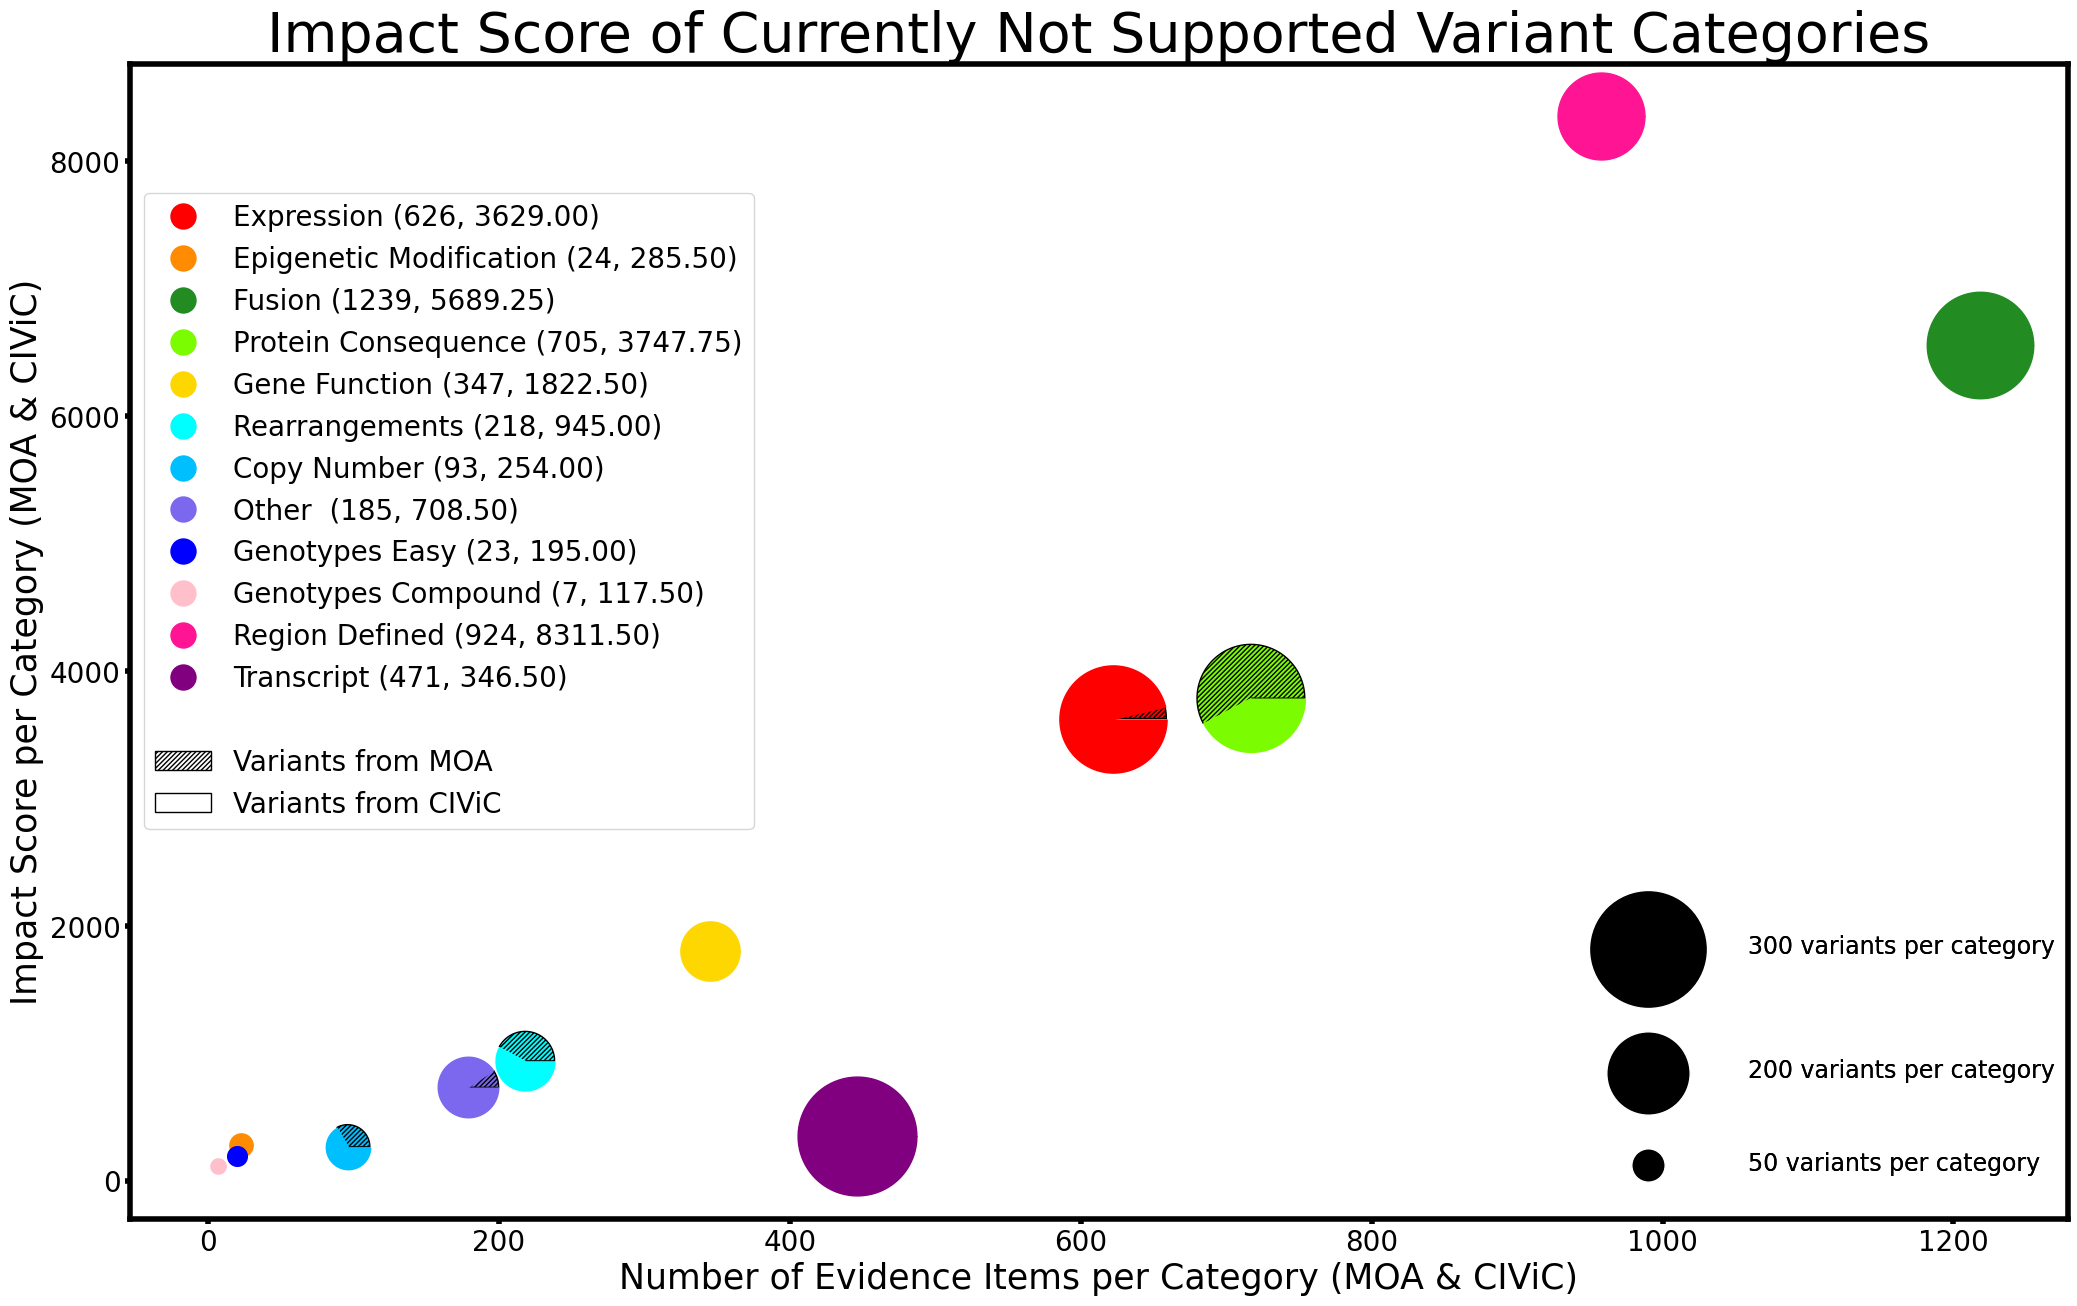

In [102]:
fig5, ax = plt.subplots(figsize=(25, 15))
legend_element_list = []
colors = [
    "red", "darkorange", "forestgreen", "lawngreen", "gold", "cyan",
     "deepskyblue", "mediumslateblue", "blue", "pink", "deeppink", "purple"
]
variant_category = variant_category_list

for i in range(12):
    ratio = ratio_list[i]
    size = moa_civic_variant_sum_list[i] * 20
    cat_coor_label = cat_to_coords_list[i]

    # Both will always have b
    x = [0] + np.cos(np.linspace(2 * np.pi * ratio, 2 * np.pi, 100)).tolist()
    y = [0] + np.sin(np.linspace(2 * np.pi * ratio, 2 * np.pi, 100)).tolist()
    marker_b = np.column_stack([x, y])

    if ratio:
        # use both a & b
        x = [0] + np.cos(np.linspace(0, 2 * np.pi * ratio, 100)).tolist()
        y = [0] + np.sin(np.linspace(0, 2 * np.pi * ratio, 100)).tolist()
        marker_a = np.column_stack([x, y])

        ax.scatter(
            moa_civic_evidence_sum_list[i], moa_civic_impact_score_list[i], marker=marker_a, s=size,
            facecolor=colors[i], edgecolors='black', hatch='///////'
        )
    
    ax.scatter(
        moa_civic_evidence_sum_list[i],moa_civic_impact_score_list[i], marker=marker_b, s=size, facecolor=colors[i], label = cat_coor_label
    )
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Expression (626, 3629.00)',
                          markerfacecolor='red', markersize=20),
                   Line2D([0], [0], marker='o', color='w', label='Epigenetic Modification (24, 285.50)',
                          markerfacecolor='darkorange', markersize=20),
                   Line2D([0], [0], marker='o', color='w', label='Fusion (1239, 5689.25)',
                          markerfacecolor='forestgreen', markersize=20),       
                   Line2D([0], [0], marker='o', color='w', label='Protein Consequence (705, 3747.75)',
                          markerfacecolor='lawngreen', markersize=20),       
                   Line2D([0], [0], marker='o', color='w', label='Gene Function (347, 1822.50)',
                          markerfacecolor='gold', markersize=20),       
                   Line2D([0], [0], marker='o', color='w', label='Rearrangements (218, 945.00)',
                          markerfacecolor='cyan', markersize=20),       
                   Line2D([0], [0], marker='o', color='w', label='Copy Number (93, 254.00)',
                          markerfacecolor='deepskyblue', markersize=20),
                   Line2D([0], [0], marker='o', color='w', label='Other  (185, 708.50)',
                          markerfacecolor='mediumslateblue', markersize=20),
                   Line2D([0], [0], marker='o', color='w', label='Genotypes Easy (23, 195.00)',
                          markerfacecolor='blue', markersize=20),       
                   Line2D([0], [0], marker='o', color='w', label='Genotypes Compound (7, 117.50)',
                          markerfacecolor='pink', markersize=20),       
                   Line2D([0], [0], marker='o', color='w', label='Region Defined (924, 8311.50)',
                          markerfacecolor='deeppink', markersize=20),       
                   Line2D([0], [0], marker='o', color='w', label='Transcript (471, 346.50)',
                          markerfacecolor='purple', markersize=20),
                   Line2D([0], [0], color='w',
                          markerfacecolor='white'),       
                   mpatches.Circle(xy=(0,0), radius=1, edgecolor="black", facecolor= "white", hatch='///////', label='Variants from MOA'), 
                   mpatches.Circle(xy=(0,0), radius=1, edgecolor="black", facecolor= "white", label='Variants from CIViC')]
legend_2_elements= [Line2D([0], [0], color='w',
                          markerfacecolor='white'),
                     Line2D([0], [0], color='w',
                          markerfacecolor='white'),
                     Line2D([0], [0], color='w',
                          markerfacecolor='white'),
                     Line2D([0], [0], marker='o', color='w', label='          300 variants per category',
                          markerfacecolor='black', markersize=85),
                     Line2D([0], [0], color='k',
                          markerfacecolor='white'),
                     Line2D([0], [0], color='w',
                          markerfacecolor='white'),
                     Line2D([0], [0], color='w',
                          markerfacecolor='white'),
                     Line2D([0], [0], marker='o', color='w', label='          200 variants per category',
                          markerfacecolor='black', markersize=60),
                     Line2D([0], [0], color='k',
                          markerfacecolor='white'),
                     Line2D([0], [0], color='w',
                          markerfacecolor='white'),
                     
                     Line2D([0], [0], marker='o', color='w', label='          50 variants per category',
                          markerfacecolor='black', markersize=24),
                     Line2D([0], [0], color='w',
                          markerfacecolor='white')]

# Create the figure
first_legend = ax.legend(handles=legend_elements,loc='lower left', bbox_to_anchor=(0., .325, 3, .550), fontsize= 20)
# first_legend._legend_box.align = "left"
ax.add_artist(first_legend)
ax.set_xlabel('Number of Evidence Items per Category (MOA & CIViC)', fontsize= 25)
ax.set_ylabel('Impact Score per Category (MOA & CIViC)', fontsize= 25)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)
ax.tick_params(width=4)
second_legend = ax.legend(handles=legend_2_elements, loc='lower right', frameon=False)
ax.add_artist(second_legend)
plt.title("Impact Score of Currently Not Supported Variant Categories", fontsize=40)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.setp(plt.gca().get_legend().get_texts(), fontsize='17')

plt.savefig('myfig2.jpeg', dpi=1000)



plt.show()
